# Speed Sign Recognition using Deep Learning

## Algorithm used -CNN (Convolutional Neural Network)


In [ ]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
import pickle

###  Reading Datasets

In [214]:
path = 'mypath'
testRatio = 0.2
valRatio = 0.2
imageDimensions= (60,60,3)
batchSizeVal= 50
epochsVal = 10


In [217]:
count = 0
images = []     # LIST CONTAINING ALL THE IMAGES
classNo = []    # LIST CONTAINING ALL THE CORRESPONDING CLASS ID OF IMAGES
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses = len(myList)

Total Classes Detected: 5


In [218]:
count = 0
images = []     # LIST CONTAINING ALL THE IMAGES
classNo = []    # LIST CONTAINING ALL THE CORRESPONDING CLASS ID OF IMAGES
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses = len(myList)
# print(myList)
print("Importing Classes .......")
for x in range(0,5):
    myPicList = os.listdir(path+"/"+str(x))
#     print(myPicList)
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg,(60,60))
        images.append(curImg)
        classNo.append(x)
    print(x,end= " ")
print(" ")
print("Total Images in Images List = ",len(images))
print("Total IDS in classNo List= ",len(classNo))


Total Classes Detected: 5
Importing Classes .......
0 1 2 3 4  
Total Images in Images List =  1528
Total IDS in classNo List=  1528


### Spliting training and testing datas
First we are converting an image into an numpy array. For easy visulatization of each pixel value of an image.

In [219]:
images = np.array(images)
classNo = np.array(classNo)
print(images.shape)

# SPLITTING THE DATA
X_train,X_test,y_train,y_test = train_test_split(images,classNo,test_size=testRatio)
X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=valRatio)
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(1528, 60, 60, 3)
(977, 60, 60, 3)
(306, 60, 60, 3)
(245, 60, 60, 3)


### Exploring the total number of images in class

[149, 202, 220, 206, 200]


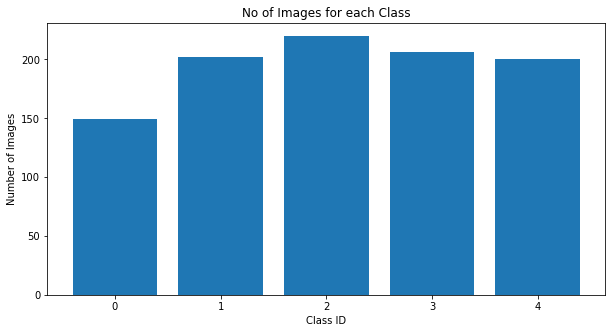

In [220]:
numOfSamples= []
for x in range(0,noOfClasses):
    #print(len(np.where(y_train==x)[0]))
    numOfSamples.append(len(np.where(y_train==x)[0]))
print(numOfSamples)

plt.figure(figsize=(10,5))
plt.bar(range(0,noOfClasses),numOfSamples)
plt.title("No of Images for each Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

### Preprocessing the data



In [221]:
def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

X_train= np.array(list(map(preProcessing,X_train)))
X_test= np.array(list(map(preProcessing,X_test)))
X_validation= np.array(list(map(preProcessing,X_validation)))


In [222]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)


In [223]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)

In [224]:
y_train = to_categorical(y_train,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)


## Training the model

In [225]:
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3, 3)
    sizeOfPool = (2,2)
    noOfNodes= 500

    model = Sequential()
    model.add((Conv2D(noOfFilters,sizeOfFilter1,input_shape=(imageDimensions[0],
                      imageDimensions[1],1),activation='relu')))
    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(noOfNodes,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))

    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

model = myModel()
print(model.summary())


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 56, 56, 60)        1560      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 52, 52, 60)        90060     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 26, 26, 60)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 24, 24, 30)        16230     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 22, 22, 30)        8130      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 11, 11, 30)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 11, 11, 30)       

In [226]:
history = model.fit_generator(dataGen.flow(X_train,y_train,
                                 batch_size=batchSizeVal),
                                 epochs=epochsVal,
                                 validation_data=(X_validation,y_validation),
                                 shuffle=1)


Epoch 1/10
20/20 [==============================] - 38s 2s/step - loss: 1.6108 - accuracy: 0.2068 - val_loss: 1.5685 - val_accuracy: 0.3224
Epoch 2/10
20/20 [==============================] - 41s 2s/step - loss: 1.5594 - accuracy: 0.3153 - val_loss: 1.6223 - val_accuracy: 0.2041
Epoch 3/10
20/20 [==============================] - 35s 2s/step - loss: 1.5066 - accuracy: 0.3142 - val_loss: 1.4575 - val_accuracy: 0.3224
Epoch 4/10
20/20 [==============================] - 32s 2s/step - loss: 1.4034 - accuracy: 0.4360 - val_loss: 1.1813 - val_accuracy: 0.5551
Epoch 5/10
20/20 [==============================] - 32s 2s/step - loss: 1.3034 - accuracy: 0.4698 - val_loss: 1.0417 - val_accuracy: 0.5714
Epoch 6/10
20/20 [==============================] - 32s 2s/step - loss: 1.1579 - accuracy: 0.5619 - val_loss: 0.8669 - val_accuracy: 0.6735
Epoch 7/10
20/20 [==============================] - 32s 2s/step - loss: 1.0716 - accuracy: 0.5752 - val_loss: 0.8050 - val_accuracy: 0.7510
Epoch 8/10
20/20 [==

In [227]:
model.metrics_names

['loss', 'accuracy']

###  Evaluating the model

In [228]:
model.evaluate(X_test,y_test)

10/10 [==============================] - 2s 230ms/step - loss: 0.4838 - accuracy: 0.8497


[0.483786404132843, 0.8496732115745544]

## Saving the model

In [230]:
model.save('speedlimitmodel.h5')
print("Saving the model as mnist.h5")

Saving the model as mnist.h5


## Testing the model on unseen images

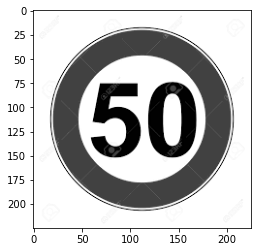

In [292]:
img = cv2.imread('path of new image',cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap ='gray')

In [293]:
img = cv2.equalizeHist(img)
img = img/255


In [294]:
img = cv2.resize(img,(60,60))

img = img.reshape(1,60,60,1)



In [295]:
classIndex = int(model.predict_classes(img))

predictions = model.predict(img)

probVal= np.amax(predictions)
# print(classIndex,probVal)

In [287]:
if classIndex == 0:
    print('the speed limit is predicted as 20 km/h')
if classIndex == 1:
    print('the speed limit is predicted as 30 km/h')
if classIndex == 2:
    print('the speed limit is predicted as 50 km/h')
if classIndex == 3:
    print('the speed limit is predicted as 80 km/h')
if classIndex == 4:
    print('the speed limit is predicted as 100 km/h')

the spped limit is predicted as 50 km/h
